The idea of the figs is to make them good to illustrate concepts using real data, rather than to generate the most accurate representation of the data show. So make sure you understand what is going down if you plan to use them for something where accurate depiction is the most important objective.

In [1]:
from __future__ import annotations

from matplotlib import pyplot as plt
import matplotlib
import vizta
from dataclasses import dataclass
import timsrust_pyo3
from loguru import logger
import polars as pl
import numpy as np
import sqlite3
from tqdm.auto import tqdm

vizta.mpl.set_theme(context="talk")

/Users/sebastianpaez/git/2024_dev_ionmesh_talk/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


('#001425', '#C8102E')

In [2]:
# This implementations is PRETTY SLOW ... but it works
# I might revisit later ... if you need it to be fast feel free to
# open an issue and we can talk about it!


@dataclass
class DenseFrame:
    rt: float
    intensities: list[int]
    mzs: list[float]
    imss: list[float]

    @classmethod
    def from_frame(cls, frame: timsrust_pyo3.PyFrame, reader: timsrust_pyo3.TimsReader):
        mzs = reader.resolve_mzs(frame.tof_indices)
        out_imss = [None] * len(mzs)
        last_so = 0
        for ims, so in zip(
            reader.resolve_scans(list(range(1, len(frame.scan_offsets) + 1))),
            frame.scan_offsets,
            strict=True,
        ):
            out_imss[last_so:so] = [ims] * (so - last_so)
            last_so = so

        return cls(
            rt=frame.rt,
            intensities=frame.intensities,
            mzs=mzs,
            imss=out_imss,
        )

    @classmethod
    def denseframe_group_to_df(self, denseframe_group: list[DenseFrame]):
        expected_len = sum(len(f.intensities) for f in denseframe_group)
        data = {
            "rt": [f.rt for f in denseframe_group],
            "intensities": [f.intensities for f in denseframe_group],
            "mzs": [f.mzs for f in denseframe_group],
            "imss": [f.imss for f in denseframe_group],
        }
        data = pl.DataFrame(data)
        # Explode the lists
        data = data.explode(["intensities", "mzs", "imss"])
        if len(data) != expected_len:
            raise RuntimeError("Dataframe length does not match expected length")
        return data


@dataclass
class DiaWindow:
    group: int
    scan_begin: int
    scan_end: int
    isolation_mz: float
    isolation_width: float
    collision_energy: float

    @classmethod
    def mapping_from_sql(cls, sql_file):
        conn = sqlite3.connect(sql_file)
        curr = conn.cursor()
        window_data = curr.execute("SELECT * FROM DiaFrameMsMsWindows").fetchall()
        logger.debug(window_data)
        info_data = curr.execute("SELECT * FROM DiaFrameMsMsInfo").fetchall()
        curr.close()
        conn.close()
        index_to_group = {frame: group for frame, group in info_data}

        group_to_windows = {}

        for group, *window in tqdm(window_data, desc="Organizing winows"):
            window_data = DiaWindow(group, *window)
            if group not in group_to_windows:
                group_to_windows[group] = []

            group_to_windows[group].append(window_data)

        logger.info(group_to_windows)
        return index_to_group, group_to_windows


@dataclass
class QuadResolver:
    index_to_group: dict[int, int]
    group_to_windows: dict[int, list[DiaWindow]]
    raw_dia_frames: list[timsrust_pyo3.PyFrame]
    raw_ms1_frames: list[timsrust_pyo3.PyFrame]
    reader: timsrust_pyo3.TimsReader
    ms1_tic: list[tuple[float, float]]

    @classmethod
    def from_file(cls, file):
        logger.info("Starting reader")
        reader = timsrust_pyo3.TimsReader(file)
        logger.info("Reading DIA metadata")
        index_to_group, group_to_windows = DiaWindow.mapping_from_sql(
            file + "/analysis.tdf"
        )
        logger.info("Reading all frames")
        allframes = reader.read_all_frames()
        dia_frames = [f for f in allframes if f.frame_type == 2]
        dia_frames.sort(key=lambda x: x.rt)
        raw_ms1_frames = [f for f in allframes if f.frame_type == 0]
        raw_ms1_frames.sort(key=lambda x: x.rt)
        ms1_ticks = [(f.rt, sum(f.intensities)) for f in allframes if f.frame_type == 0]
        logger.info(
            f"{len(allframes)} frames read, {len(dia_frames)} DIA frames, {len(raw_ms1_frames)} MS1 frames"
        )
        return cls(
            index_to_group,
            group_to_windows,
            dia_frames,
            raw_ms1_frames,
            reader,
            ms1_ticks,
        )

    def get_windowgroup_denseframe_range(self, min_rt, max_rt, group) -> DenseFrame:
        out = []
        rts = np.array([f.rt for f in self.raw_dia_frames])

        rt_ranges_start = np.searchsorted(rts, min_rt, side="left")
        rt_ranges_end = np.searchsorted(rts, max_rt, side="right")

        wg = self.group_to_windows[group]
        logger.info(f"Sample window group -> {wg[0]}")

        for frame in self.raw_dia_frames[rt_ranges_start:rt_ranges_end]:
            cg = self.index_to_group[frame.index]
            if cg == group:
                out.append(DenseFrame.from_frame(frame, self.reader))

        out = DenseFrame.denseframe_group_to_df(out)
        return out

    def get_ms1_denseframe_range(self, min_rt, max_rt) -> DenseFrame:
        out = []
        rts = np.array([f.rt for f in self.raw_ms1_frames])
        rt_ranges_start = np.searchsorted(rts, min_rt, side="left")
        rt_ranges_end = np.searchsorted(rts, max_rt, side="right")
        logger.debug(f"Reading {rt_ranges_start} to {rt_ranges_end}")
        for frame in self.raw_ms1_frames[rt_ranges_start:rt_ranges_end]:
            out.append(DenseFrame.from_frame(frame, self.reader))

        out = DenseFrame.denseframe_group_to_df(out)
        return out

    def get_per_group_tic(self):
        out: dict[int, tuple[float, float]] = {}
        for frame in self.raw_dia_frames:
            group = self.index_to_group[frame.index]
            out.get(group, []).append((frame.rt, sum(frame.intensities)))
        return out

In [3]:
file = "../data/230510_PRTC_12.d"
qr = QuadResolver.from_file(file)
qr

2024-06-02 23:28:48.062 | INFO     | __main__:from_file:94 - Starting reader
2024-06-02 23:28:48.063 | INFO     | __main__:from_file:96 - Reading DIA metadata
2024-06-02 23:28:48.065 | DEBUG    | __main__:mapping_from_sql:64 - [(1, 101, 400, 812.5, 25.0, 42.83272727272727), (1, 400, 547, 612.5, 25.0, 32.290909090909096), (1, 547, 701, 412.5, 25.0, 25.152727272727276), (2, 101, 375, 837.5, 25.0, 43.4), (2, 375, 531, 637.5, 25.0, 33.236363636363635), (2, 531, 701, 437.5, 25.0, 25.530909090909095), (3, 101, 359, 862.5, 25.0, 43.77818181818182), (3, 359, 515, 662.5, 25.0, 33.99272727272727), (3, 515, 701, 462.5, 25.0, 25.90909090909091), (4, 101, 334, 887.5, 25.0, 44.39272727272727), (4, 334, 490, 687.5, 25.0, 35.17454545454545), (4, 490, 701, 487.5, 25.0, 26.523636363636367), (5, 101, 317, 912.5, 25.0, 44.770909090909086), (5, 317, 474, 712.5, 25.0, 35.978181818181824), (5, 474, 701, 512.5, 25.0, 26.901818181818186), (6, 101, 301, 937.5, 25.0, 45.14909090909091), (6, 301, 457, 737.5, 25.0

QuadResolver(index_to_group={2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7, 9: 8, 11: 1, 12: 2, 13: 3, 14: 4, 15: 5, 16: 6, 17: 7, 18: 8, 20: 1, 21: 2, 22: 3, 23: 4, 24: 5, 25: 6, 26: 7, 27: 8, 29: 1, 30: 2, 31: 3, 32: 4, 33: 5, 34: 6, 35: 7, 36: 8, 38: 1, 39: 2, 40: 3, 41: 4, 42: 5, 43: 6, 44: 7, 45: 8, 47: 1, 48: 2, 49: 3, 50: 4, 51: 5, 52: 6, 53: 7, 54: 8, 56: 1, 57: 2, 58: 3, 59: 4, 60: 5, 61: 6, 62: 7, 63: 8, 65: 1, 66: 2, 67: 3, 68: 4, 69: 5, 70: 6, 71: 7, 72: 8, 74: 1, 75: 2, 76: 3, 77: 4, 78: 5, 79: 6, 80: 7, 81: 8, 83: 1, 84: 2, 85: 3, 86: 4, 87: 5, 88: 6, 89: 7, 90: 8, 92: 1, 93: 2, 94: 3, 95: 4, 96: 5, 97: 6, 98: 7, 99: 8, 101: 1, 102: 2, 103: 3, 104: 4, 105: 5, 106: 6, 107: 7, 108: 8, 110: 1, 111: 2, 112: 3, 113: 4, 114: 5, 115: 6, 116: 7, 117: 8, 119: 1, 120: 2, 121: 3, 122: 4, 123: 5, 124: 6, 125: 7, 126: 8, 128: 1, 129: 2, 130: 3, 131: 4, 132: 5, 133: 6, 134: 7, 135: 8, 137: 1, 138: 2, 139: 3, 140: 4, 141: 5, 142: 6, 143: 7, 144: 8, 146: 1, 147: 2, 148: 3, 149: 4, 150: 5, 151

In [4]:
qr.group_to_windows

{1: [DiaWindow(group=1, scan_begin=101, scan_end=400, isolation_mz=812.5, isolation_width=25.0, collision_energy=42.83272727272727),
  DiaWindow(group=1, scan_begin=400, scan_end=547, isolation_mz=612.5, isolation_width=25.0, collision_energy=32.290909090909096),
  DiaWindow(group=1, scan_begin=547, scan_end=701, isolation_mz=412.5, isolation_width=25.0, collision_energy=25.152727272727276)],
 2: [DiaWindow(group=2, scan_begin=101, scan_end=375, isolation_mz=837.5, isolation_width=25.0, collision_energy=43.4),
  DiaWindow(group=2, scan_begin=375, scan_end=531, isolation_mz=637.5, isolation_width=25.0, collision_energy=33.236363636363635),
  DiaWindow(group=2, scan_begin=531, scan_end=701, isolation_mz=437.5, isolation_width=25.0, collision_energy=25.530909090909095)],
 3: [DiaWindow(group=3, scan_begin=101, scan_end=359, isolation_mz=862.5, isolation_width=25.0, collision_energy=43.77818181818182),
  DiaWindow(group=3, scan_begin=359, scan_end=515, isolation_mz=662.5, isolation_width=2

Text(0, 0.5, 'TIC')

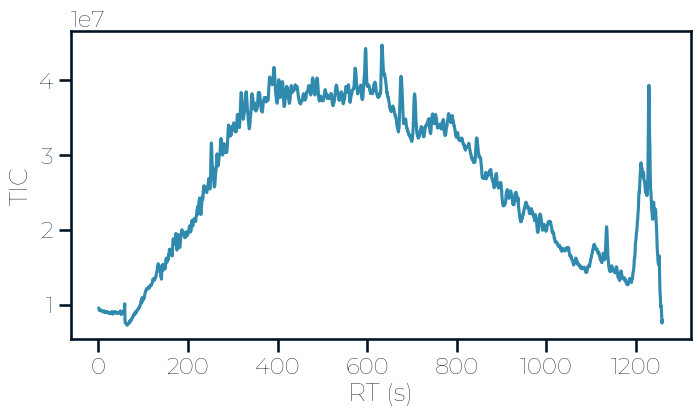

In [5]:
tic = [i for r, i in qr.ms1_tic]
rts = [r for r, i in qr.ms1_tic]

plt.rcParams["figure.figsize"] = [8, 4]

plt.plot(rts, tic)
plt.xlabel("RT (s)")
plt.ylabel("TIC")

2024-06-02 23:29:07.259 | DEBUG    | __main__:get_per_group_tic:6 - [0, 1716, 1716, 1716, 1716, 1716, 1716, 1715, 1715]


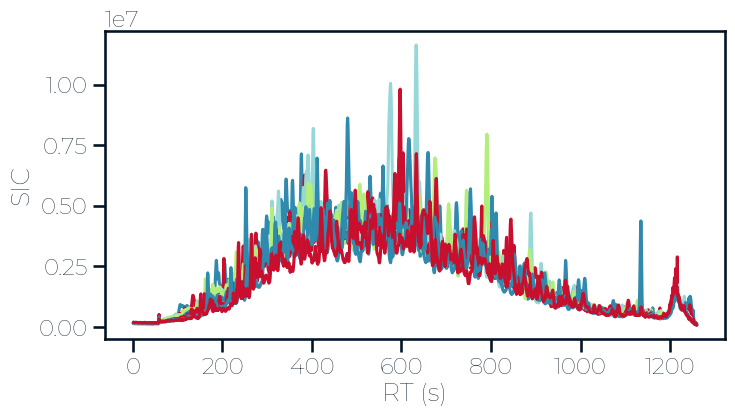

In [6]:
def get_per_group_tic(qr):
    out: dict[int, tuple[float, float]] = [[] for _ in range(1, 10)]
    for frame in qr.raw_dia_frames:
        group = qr.index_to_group[frame.index]
        out[group].append((frame.rt, sum(frame.intensities)))
    logger.debug([len(v) for v in out])
    return out


per_group_tic = get_per_group_tic(qr)
for data in per_group_tic:
    if not data:
        continue
    rts = [r for r, i in data]
    tic = [i for r, i in data]
    plt.plot(rts, tic)

plt.xlabel("RT (s)")
plt.ylabel("SIC")
plt.show()

In [7]:
start_mins = 10
range_secs = 20
df = qr.get_windowgroup_denseframe_range(
    start_mins * 60, (start_mins * 60) + range_secs, 1
)
ms1_df = qr.get_ms1_denseframe_range(start_mins * 60, (start_mins * 60) + range_secs)
print(ms1_df)
print(df)

2024-06-02 23:29:07.325 | INFO     | __main__:get_windowgroup_denseframe_range:127 - Sample window group -> DiaWindow(group=1, scan_begin=101, scan_end=400, isolation_mz=812.5, isolation_width=25.0, collision_energy=42.83272727272727)
2024-06-02 23:29:07.981 | DEBUG    | __main__:get_ms1_denseframe_range:142 - Reading 817 to 844


shape: (10_790_141, 4)
┌────────────┬─────────────┬─────────────┬──────────┐
│ rt         ┆ intensities ┆ mzs         ┆ imss     │
│ ---        ┆ ---         ┆ ---         ┆ ---      │
│ f64        ┆ i64         ┆ f64         ┆ f64      │
╞════════════╪═════════════╪═════════════╪══════════╡
│ 600.26653  ┆ 80          ┆ 221.001802  ┆ 1.418544 │
│ 600.26653  ┆ 32          ┆ 1374.970207 ┆ 1.418544 │
│ 600.26653  ┆ 152         ┆ 270.571031  ┆ 1.41767  │
│ 600.26653  ┆ 167         ┆ 270.767405  ┆ 1.41767  │
│ 600.26653  ┆ 56          ┆ 320.475646  ┆ 1.41767  │
│ …          ┆ …           ┆ …           ┆ …        │
│ 619.350149 ┆ 104         ┆ 483.907668  ┆ 0.835728 │
│ 619.350149 ┆ 152         ┆ 494.900532  ┆ 0.835728 │
│ 619.350149 ┆ 117         ┆ 516.240256  ┆ 0.835728 │
│ 619.350149 ┆ 102         ┆ 546.160331  ┆ 0.835728 │
│ 619.350149 ┆ 21          ┆ 954.008748  ┆ 0.835728 │
└────────────┴─────────────┴─────────────┴──────────┘
shape: (1_427_266, 4)
┌────────────┬─────────────┬─────────

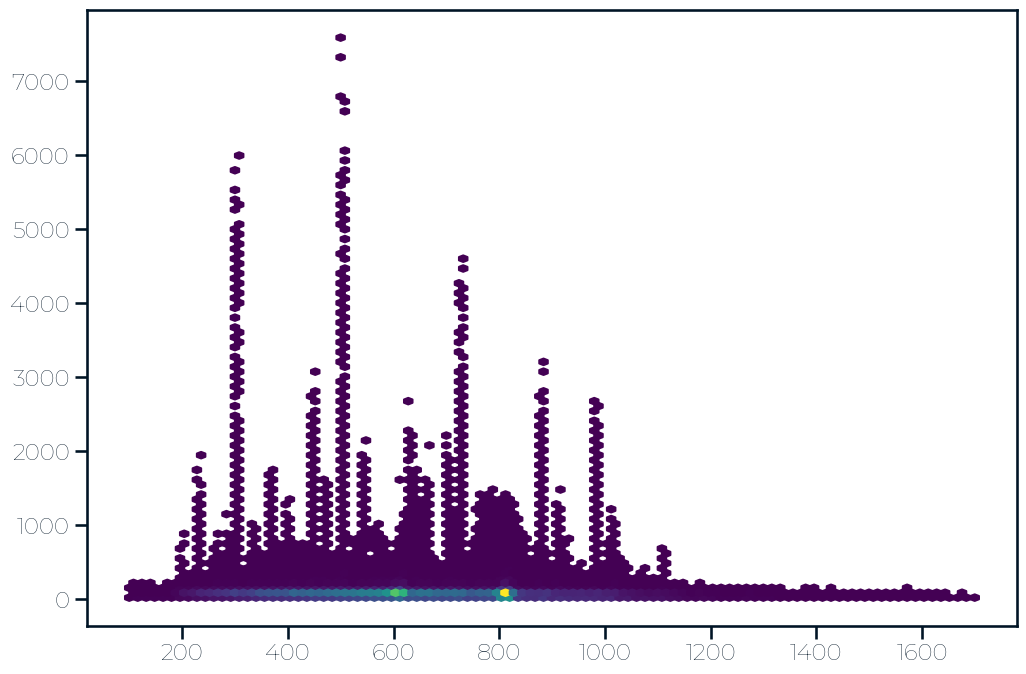

In [8]:
plt.rcParams["figure.figsize"] = (12, 8)
plt.hexbin(df["mzs"], df["intensities"], gridsize=100, cmap="viridis", mincnt=1)

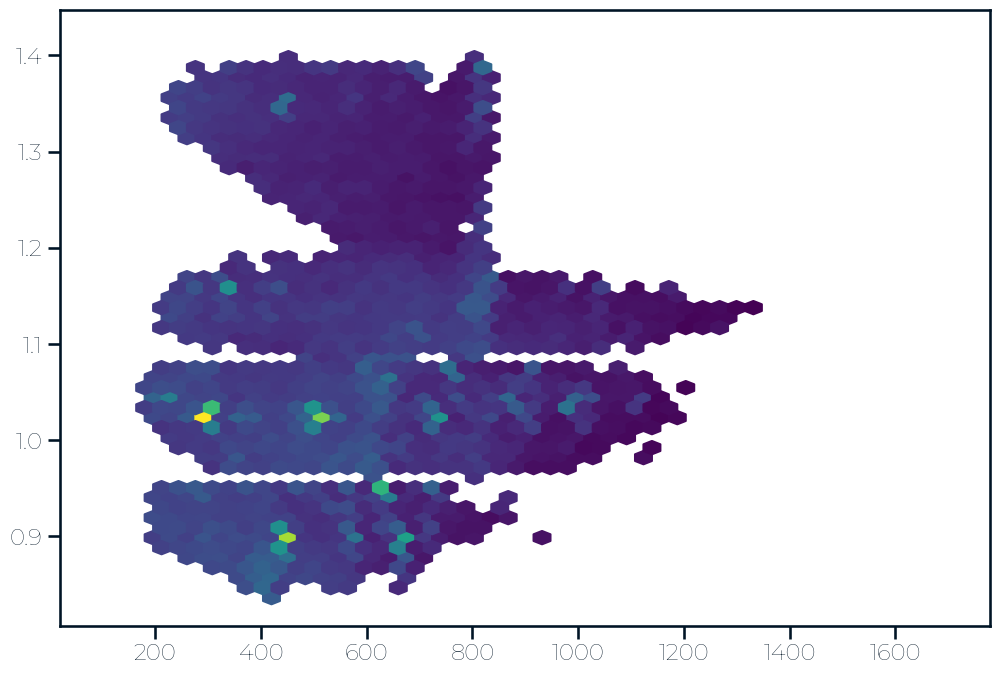

In [9]:
plt.rcParams["figure.figsize"] = (12, 8)
plt.hexbin(
    df["mzs"], df["imss"], C=df["intensities"], gridsize=50, cmap="viridis", mincnt=100
)

In [10]:
# sdf = df.filter(
#     # pl.col("mzs") > 620,
#     # pl.col("mzs") < 660,
#     pl.col("imss") > 1.0,
#     pl.col("imss") < 1.05,
#     pl.col("intensities") > 90,
# )
# sdf
sdf = df.filter(
    # pl.col("mzs") > 620,
    # pl.col("mzs") < 660,
    pl.col("imss") > 1.0,
    pl.col("imss") < 1.05,
    pl.col("intensities") > 200,
)
sdf

focus_sdf = df.filter(
    pl.col("mzs") > 542,
    pl.col("mzs") < 545,
    pl.col("imss") > 1.0,
    pl.col("imss") < 1.05,
    pl.col("intensities") > 100,
)
focus_sdf

shape: (1_734, 4)
┌────────────┬─────────────┬────────────┬──────────┐
│ rt         ┆ intensities ┆ mzs        ┆ imss     │
│ ---        ┆ ---         ┆ ---        ┆ ---      │
│ f64        ┆ i64         ┆ f64        ┆ f64      │
╞════════════╪═════════════╪════════════╪══════════╡
│ 600.34773  ┆ 121         ┆ 543.144079 ┆ 1.044563 │
│ 600.34773  ┆ 106         ┆ 543.29914  ┆ 1.041942 │
│ 600.34773  ┆ 171         ┆ 544.255079 ┆ 1.041942 │
│ 600.34773  ┆ 195         ┆ 544.255079 ┆ 1.041068 │
│ 600.34773  ┆ 170         ┆ 544.284752 ┆ 1.041068 │
│ …          ┆ …           ┆ …          ┆ …        │
│ 619.431364 ┆ 104         ┆ 544.782459 ┆ 1.019223 │
│ 619.431364 ┆ 134         ┆ 543.65039  ┆ 1.015728 │
│ 619.431364 ┆ 161         ┆ 543.552302 ┆ 1.012233 │
│ 619.431364 ┆ 111         ┆ 543.191963 ┆ 1.006117 │
│ 619.431364 ┆ 155         ┆ 542.697262 ┆ 1.005243 │
└────────────┴─────────────┴────────────┴──────────┘

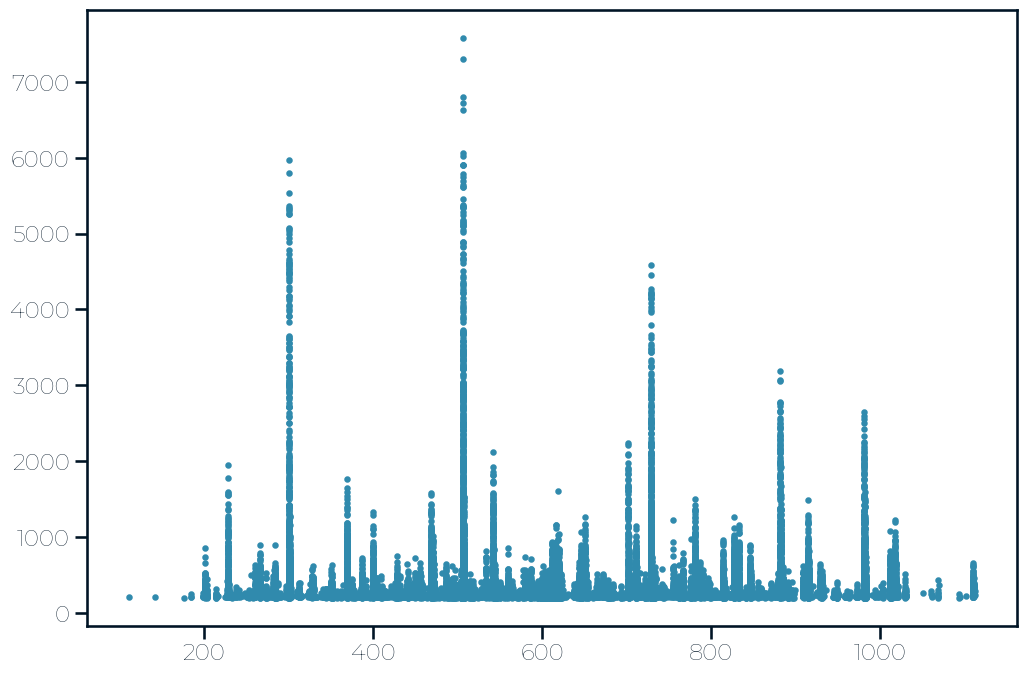

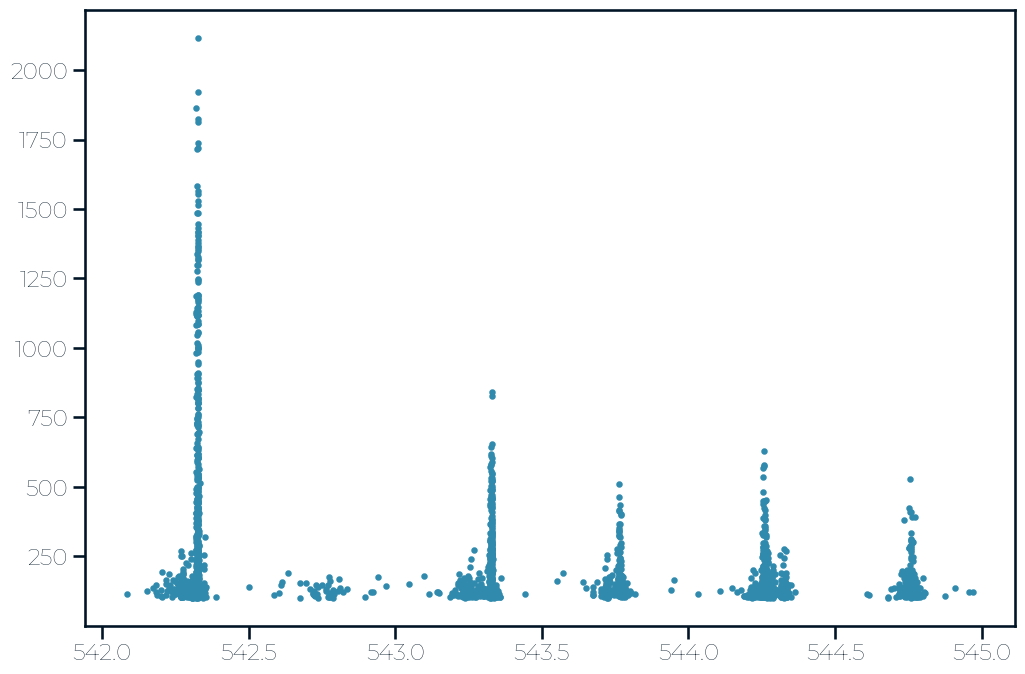

In [11]:
plt.rcParams["figure.figsize"] = (12, 8)
plt.scatter(sdf["mzs"], sdf["intensities"], s=10)
plt.show()

plt.scatter(focus_sdf["mzs"], focus_sdf["intensities"], s=10)
plt.show()

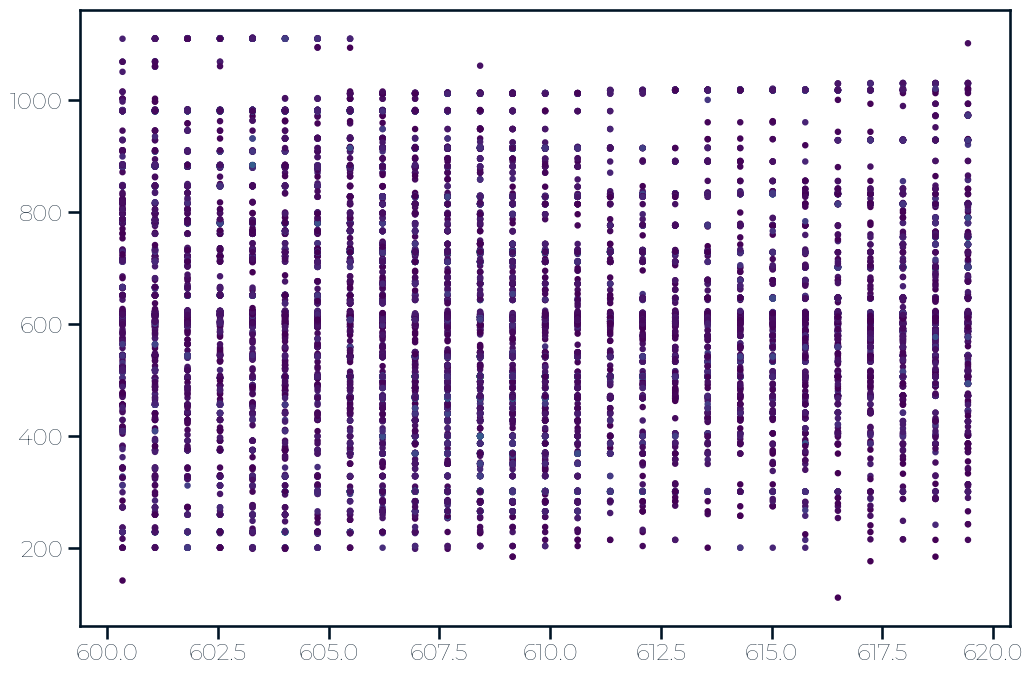

In [12]:
plt.rcParams["figure.figsize"] = (12, 8)
plt.scatter(sdf["rt"], sdf["mzs"], c=np.log(sdf["intensities"]), s=10)

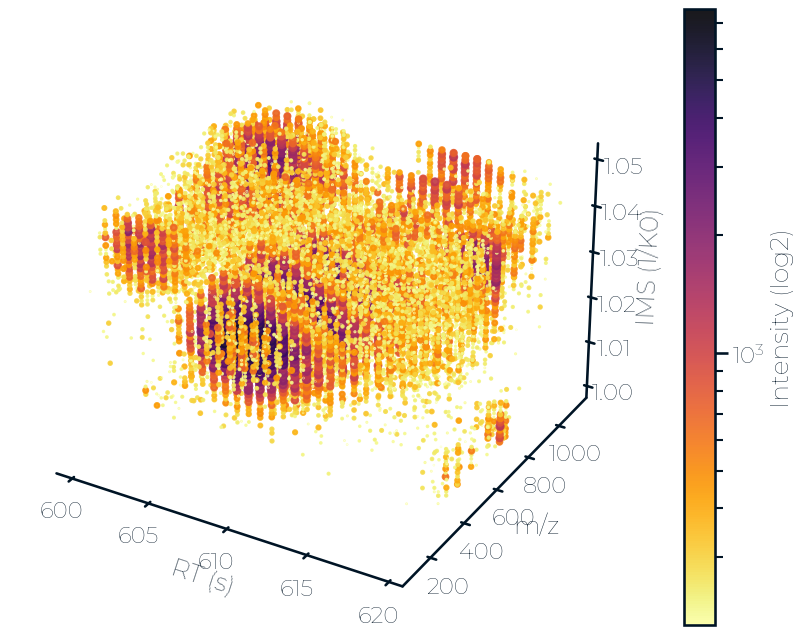

In [13]:
plt.rcParams["figure.figsize"] = (15, 8)
PARAMS = {
    "X": {"col": "rt", "label": "RT (s)", "scaling": 1.0},
    "Y": {"col": "mzs", "label": "m/z", "scaling": 0.015},
    "Z": {"col": "imss", "label": "IMS (1/K0)", "scaling": 0.03},
}

INV_PARAMS = {v["col"]: {**v, "axis": k} for k, v in PARAMS.items()}


def get_3d_default_ax():
    fig = plt.figure()
    ax = fig.add_subplot(projection="3d")
    # ax.set_xlabel("x"); ax.set_ylabel("y"); ax.set_zlabel("z")

    # make the panes transparent
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    # make the grid lines transparent
    ax.xaxis._axinfo["grid"]["color"] = (1, 1, 1, 0)
    ax.yaxis._axinfo["grid"]["color"] = (1, 1, 1, 0)
    ax.zaxis._axinfo["grid"]["color"] = (1, 1, 1, 0)

    ax.set_ylabel(PARAMS["Y"]["label"])
    ax.set_zlabel(PARAMS["Z"]["label"])
    ax.set_xlabel(PARAMS["X"]["label"])
    return fig, ax


# ys = sdf["mzs"].to_numpy()
# ax.set_ylabel("m/z")
# zs = sdf["imss"].to_numpy()
# ax.set_zlabel("IMS (1/K0)")
# xs = sdf["rt"].to_numpy()
# ax.set_xlabel("RT (s)")

ys = sdf[PARAMS["Y"]["col"]].to_numpy()
zs = sdf[PARAMS["Z"]["col"]].to_numpy()
xs = sdf[PARAMS["X"]["col"]].to_numpy()

focus_ys = focus_sdf[PARAMS["Y"]["col"]].to_numpy()
focus_zs = focus_sdf[PARAMS["Z"]["col"]].to_numpy()
focus_xs = focus_sdf[PARAMS["X"]["col"]].to_numpy()

fig, ax = get_3d_default_ax()

cs = sdf["intensities"].to_numpy()
min_log10_cs = np.log2(np.min(cs))
scaled_cs = 20 * (np.log2(cs) - min_log10_cs)

focus_cs = focus_sdf["intensities"].to_numpy()
focus_min_log10_cs = np.log2(np.min(focus_cs))
focus_scaled_cs = 20 * (np.log2(focus_cs) - focus_min_log10_cs)

# ax.view_init(azim=-20, elev=20)
scatter1 = ax.scatter(
    xs,
    ys,
    zs,
    s=scaled_cs / 2,
    c=cs,
    cmap="inferno_r",
    alpha=0.9,
    norm=matplotlib.colors.LogNorm(),
)

cb = fig.colorbar(scatter1, ax=ax)
cb.ax.set_ylabel("Intensity (log2)")
plt.show()

In [14]:
scatter1 = ax.scatter(
    xs,
    ys,
    zs,
    s=scaled_cs / 2,
    c=cs,
    cmap="inferno_r",
    alpha=0.9,
    norm=matplotlib.colors.LogNorm(),
)

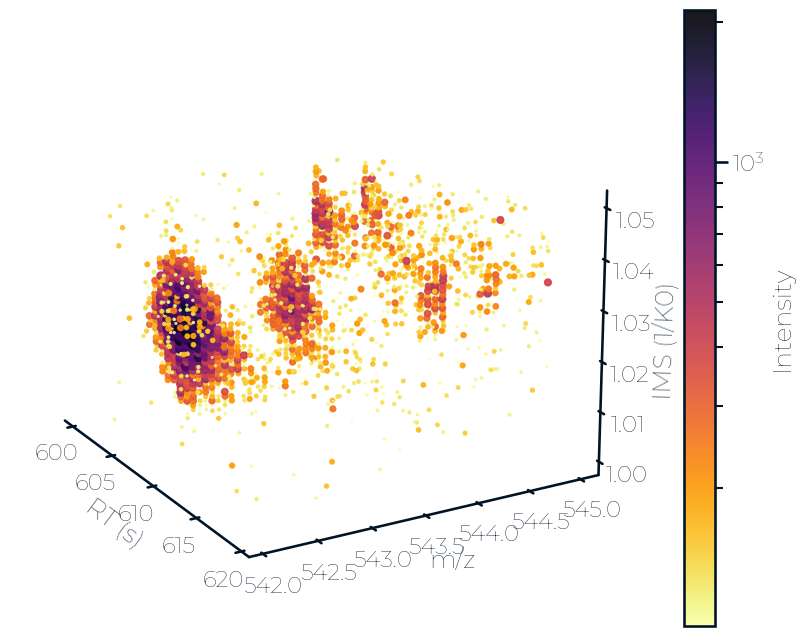

In [15]:
fig, ax = get_3d_default_ax()
ax.view_init(azim=-30, elev=20)
scatter1 = ax.scatter(
    focus_xs,
    focus_ys,
    focus_zs,
    s=focus_scaled_cs / 2,
    c=focus_cs,
    cmap="inferno_r",
    alpha=0.9,
    norm=matplotlib.colors.LogNorm(),
)
cb = fig.colorbar(scatter1, ax=ax)
cb.ax.set_ylabel("Intensity")
plt.show()

In [16]:
from sklearn.cluster import DBSCAN
import numpy as np

eps = 1
min_samples = 3
X = np.array(
    [
        xs / PARAMS["X"]["scaling"],
        ys / PARAMS["Y"]["scaling"],
        zs / PARAMS["Z"]["scaling"],
    ]
).T

clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(X)
clustering.labels_

array([  0,  -1,  -1, ..., 427, 437, 428])

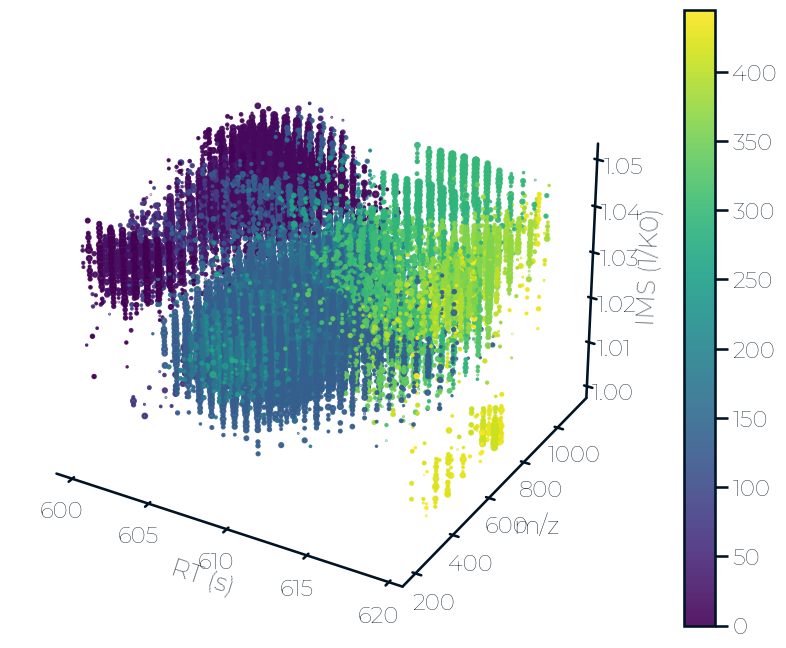

In [17]:
fig, ax = get_3d_default_ax()
scatter1 = ax.scatter(
    xs[clustering.labels_ != -1],
    ys[clustering.labels_ != -1],
    zs[clustering.labels_ != -1],
    s=scaled_cs[clustering.labels_ != -1] / 2,
    c=clustering.labels_[clustering.labels_ != -1],
    alpha=0.9,
)
fig.colorbar(scatter1, ax=ax)
plt.show()

In [18]:
def gen_centroid(arr, labels):
    if np.any(labels == -1):
        arr = arr[labels != -1]
        labels = labels[labels != -1]

    out_arr_len = np.max(labels) + 1
    out_arr = np.zeros(out_arr_len)
    out_arr_counts = np.zeros(out_arr_len)

    np.add.at(out_arr, labels, arr)
    np.add.at(out_arr_counts, labels, 1)

    out = out_arr / out_arr_counts

    return out


def sum_labels(arr, labels):
    if np.any(labels == -1):
        arr = arr[labels != -1]
        labels = labels[labels != -1]

    out_arr_len = np.max(labels) + 1
    out_arr = np.zeros(out_arr_len)

    np.add.at(out_arr, labels, arr)

    return out_arr


def gen_weighted_centroid(arr, labels, weights):
    if np.any(labels == -1):
        arr = arr[labels != -1]
        weights = weights[labels != -1]
        labels = labels[labels != -1]

    out_arr_len = np.max(labels) + 1
    out_arr = np.zeros(out_arr_len)
    out_arr_weights = np.zeros(out_arr_len)

    np.add.at(out_arr, labels, arr * weights)
    np.add.at(out_arr_weights, labels, weights)

    out = out_arr / out_arr_weights

    return out

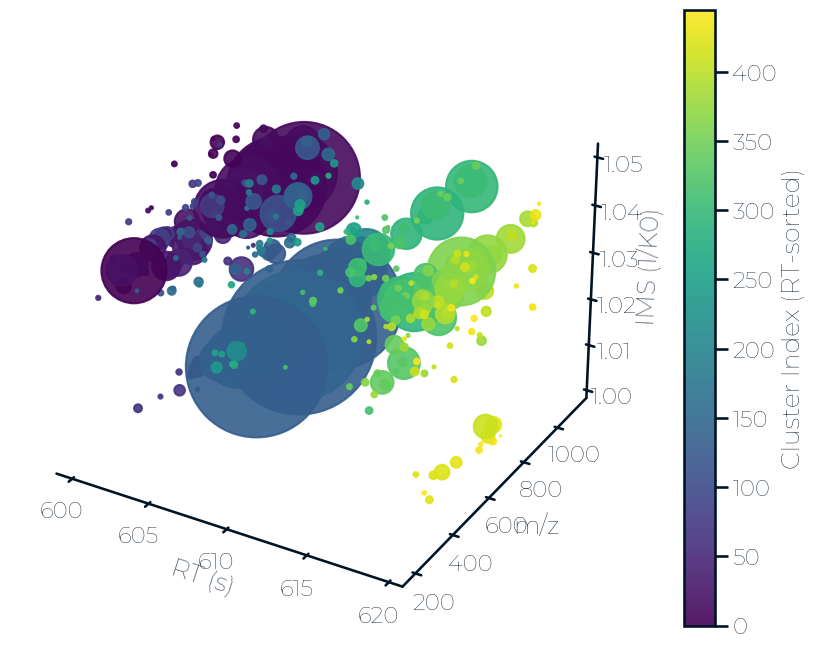

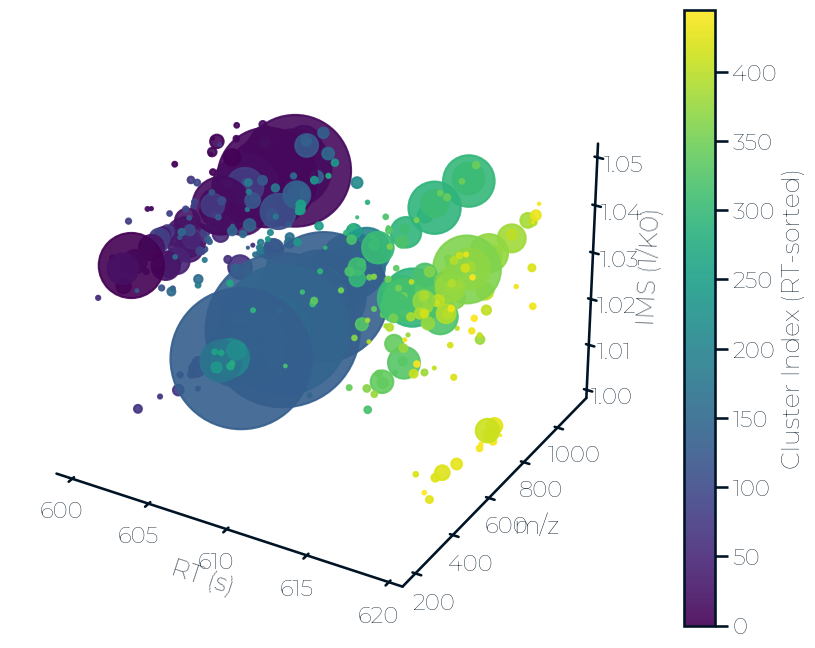

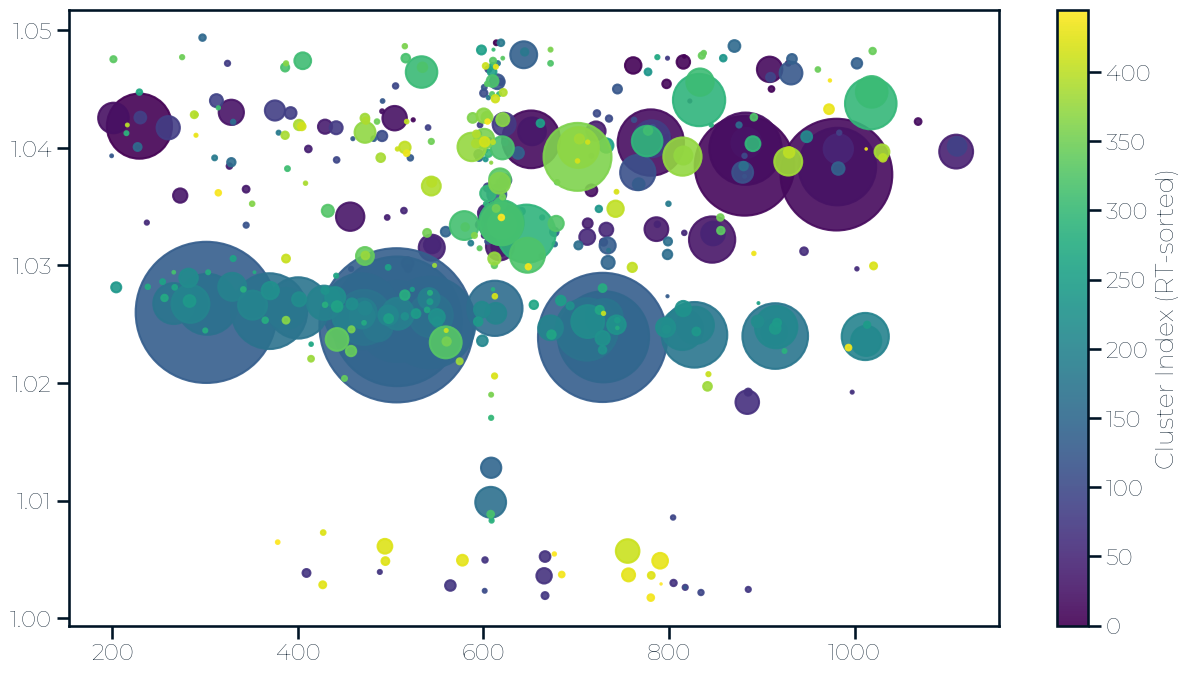

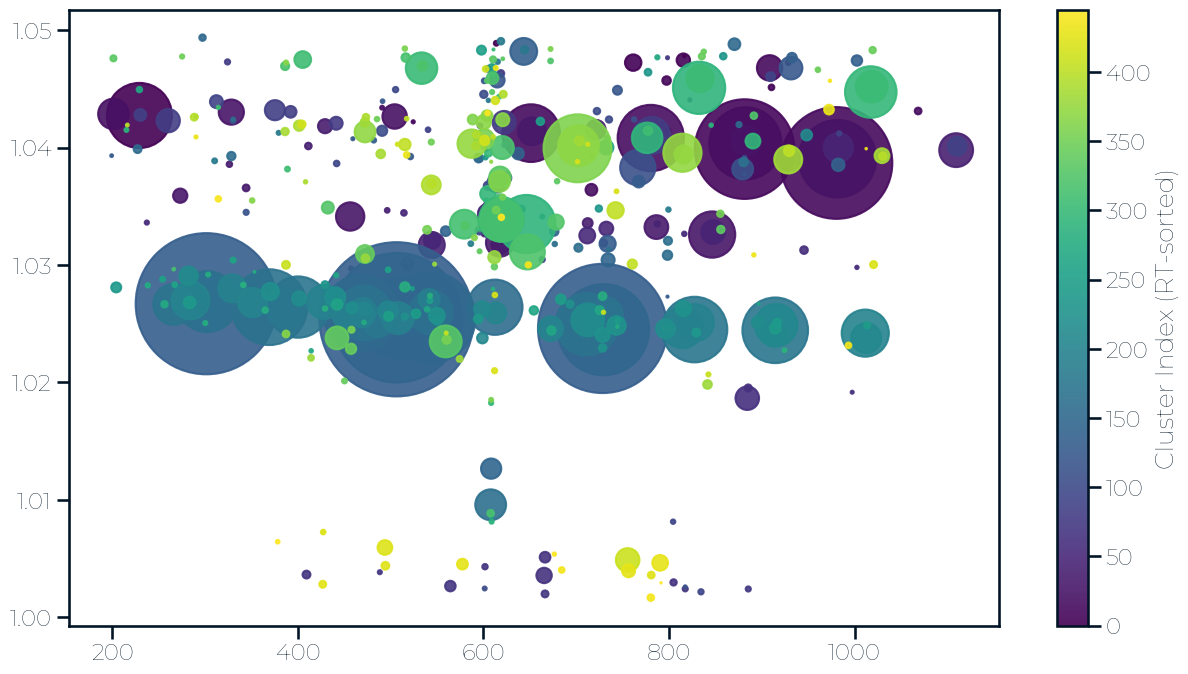

In [19]:
xs_centroided = gen_centroid(xs, clustering.labels_)
ys_centroided = gen_centroid(ys, clustering.labels_)
zs_centroided = gen_centroid(zs, clustering.labels_)
cs_centroided = sum_labels(scaled_cs, clustering.labels_)


fig, ax = get_3d_default_ax()
scatter1 = ax.scatter(
    xs_centroided,
    ys_centroided,
    zs_centroided,
    s=cs_centroided / 2,
    c=np.arange(len(xs_centroided)),
    alpha=0.9,
)
cbar = fig.colorbar(scatter1, ax=ax)
cbar.ax.set_ylabel("Cluster Index (RT-sorted)")
plt.show()


w_xs_centroided = gen_weighted_centroid(xs, clustering.labels_, cs)
w_ys_centroided = gen_weighted_centroid(ys, clustering.labels_, cs)
w_zs_centroided = gen_weighted_centroid(zs, clustering.labels_, cs)
w_cs_centroided = sum_labels(scaled_cs, clustering.labels_)

fig, ax = get_3d_default_ax()
scatter1 = ax.scatter(
    w_xs_centroided,
    w_ys_centroided,
    w_zs_centroided,
    s=w_cs_centroided / 2,
    c=np.arange(len(w_xs_centroided)),
    alpha=0.9,
)
cbar = fig.colorbar(scatter1, ax=ax)
cbar.ax.set_ylabel("Cluster Index (RT-sorted)")
plt.show()

plt.scatter(
    ys_centroided,
    zs_centroided,
    c=np.arange(len(xs_centroided)),
    s=cs_centroided / 2,
    alpha=0.9,
)
cbar = plt.colorbar()
cbar.ax.set_ylabel("Cluster Index (RT-sorted)")
plt.show()

plt.scatter(
    w_ys_centroided,
    w_zs_centroided,
    c=np.arange(len(w_xs_centroided)),
    s=w_cs_centroided / 2,
    alpha=0.9,
)
cbar = plt.colorbar()
cbar.ax.set_ylabel("Cluster Index (RT-sorted)")
plt.show()

In [20]:
plt.rcParams["figure.figsize"] = (15, 8)


def collapse_to_tolerance(*arr, intensities, tol=0.1):
    stacked = (np.stack(arr) / tol).astype(int)
    vals, inds = np.unique(stacked, axis=1, return_inverse=True)
    vals = vals * tol

    logger.info(
        f"vals_shape: {vals.shape}, inds_shape: {inds.shape}, intensities_shape: {intensities.shape}"
    )
    out_ints = sum_labels(intensities, inds)
    out_arr = [vals[i, :] for i in range(len(vals))]

    return out_arr, out_ints


def plot_mz_rt_traces(mzs, rts, intensities, num_max=200, tolerance=0.02):
    (collapsed_mzs, collapsed_rts), collapsed_ints = collapse_to_tolerance(
        mzs,
        rts,
        intensities=intensities,
        tol=tolerance,
    )

    tolerance1 = tolerance
    if not isinstance(tolerance, float):
        tolerance1 = tolerance[0]
    (collapsed_overall_mzs,), collapsed_overall_ints = collapse_to_tolerance(
        mzs,
        intensities=intensities,
        tol=tolerance1,
    )

    top_n = np.argsort(collapsed_overall_ints)[-num_max:]
    top_n_mzs = collapsed_overall_mzs[top_n]

    dist_to_top = collapsed_mzs - np.expand_dims(top_n_mzs, axis=1)
    logger.debug(f"dist_to_top: {dist_to_top.shape}")
    any_in_top = np.any(np.abs(dist_to_top) < 0.02, axis=0)

    logger.info(f"{np.unique(any_in_top, return_counts=True)}")

    fig, ax = get_3d_default_ax()
    ax.set_zlabel("Intensity")
    stems = ax.stem(
        collapsed_rts[any_in_top],
        collapsed_mzs[any_in_top],
        collapsed_ints[any_in_top],
        linefmt="",
        markerfmt=".",
    )
    # plt.setp(stems, 'linewidth', 3)
    stems[0].set_markersize(0)
    # stems[0].set(alpha=0.7)
    stems[1].set_linewidth(1.5)
    stems[1].set_color("#666666")
    stems[1].set(alpha=0.4)
    stems[2].set_linewidth(0)

    offset = np.log10(np.min(collapsed_ints[any_in_top]))
    scatter = ax.scatter(
        collapsed_rts[any_in_top],
        collapsed_mzs[any_in_top],
        collapsed_ints[any_in_top],
        s=20 * (np.log10(collapsed_ints[any_in_top]) - offset),
        c=collapsed_ints[any_in_top],
        cmap="inferno_r",
        alpha=0.9,
        norm=matplotlib.colors.LogNorm(),
    )

    ax.view_init(azim=-30, elev=20)
    plt.tight_layout()
    return fig, ax, stems, scatter

2024-06-02 23:29:12.688 | INFO     | __main__:collapse_to_tolerance:9 - vals_shape: (2, 5285), inds_shape: (17948,), intensities_shape: (17948,)
2024-06-02 23:29:12.696 | INFO     | __main__:collapse_to_tolerance:9 - vals_shape: (1, 1904), inds_shape: (17948,), intensities_shape: (17948,)
2024-06-02 23:29:12.745 | DEBUG    | __main__:plot_mz_rt_traces:39 - dist_to_top: (200, 5285)
2024-06-02 23:29:12.751 | INFO     | __main__:plot_mz_rt_traces:42 - (array([False,  True]), array([2845, 2440]))


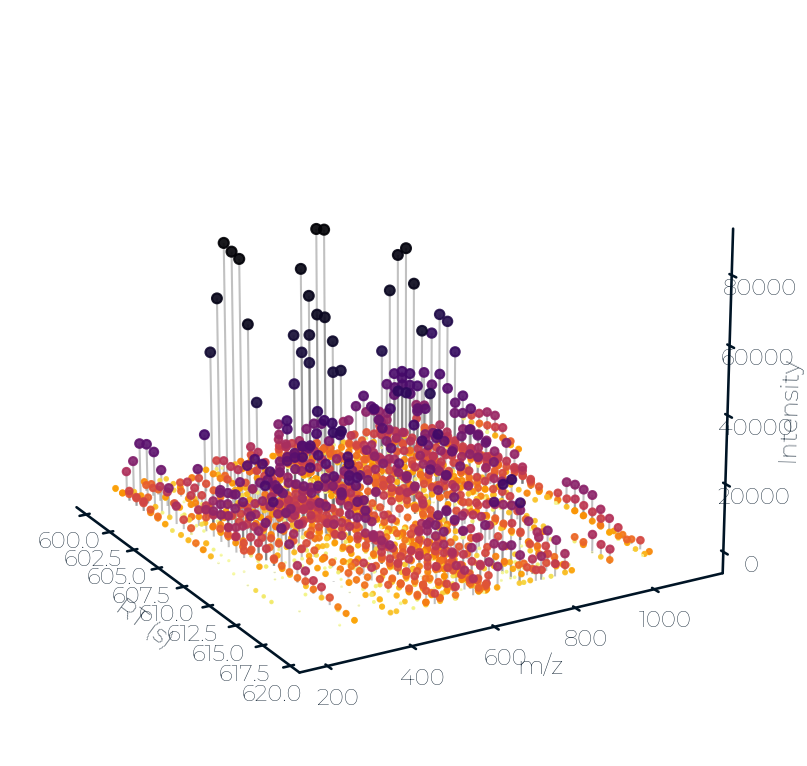

In [21]:
fig, ax, stems, scatter = plot_mz_rt_traces(
    sdf["mzs"].to_numpy(),
    sdf["rt"].to_numpy(),
    sdf["intensities"].to_numpy(),
    num_max=200,
)
plt.show()

2024-06-02 23:29:12.977 | INFO     | __main__:collapse_to_tolerance:9 - vals_shape: (2, 4563), inds_shape: (27808,), intensities_shape: (27808,)
2024-06-02 23:29:12.988 | INFO     | __main__:collapse_to_tolerance:9 - vals_shape: (1, 886), inds_shape: (27808,), intensities_shape: (27808,)
2024-06-02 23:29:12.994 | DEBUG    | __main__:plot_mz_rt_traces:39 - dist_to_top: (500, 4563)
2024-06-02 23:29:12.997 | INFO     | __main__:plot_mz_rt_traces:42 - (array([False,  True]), array([ 447, 4116]))


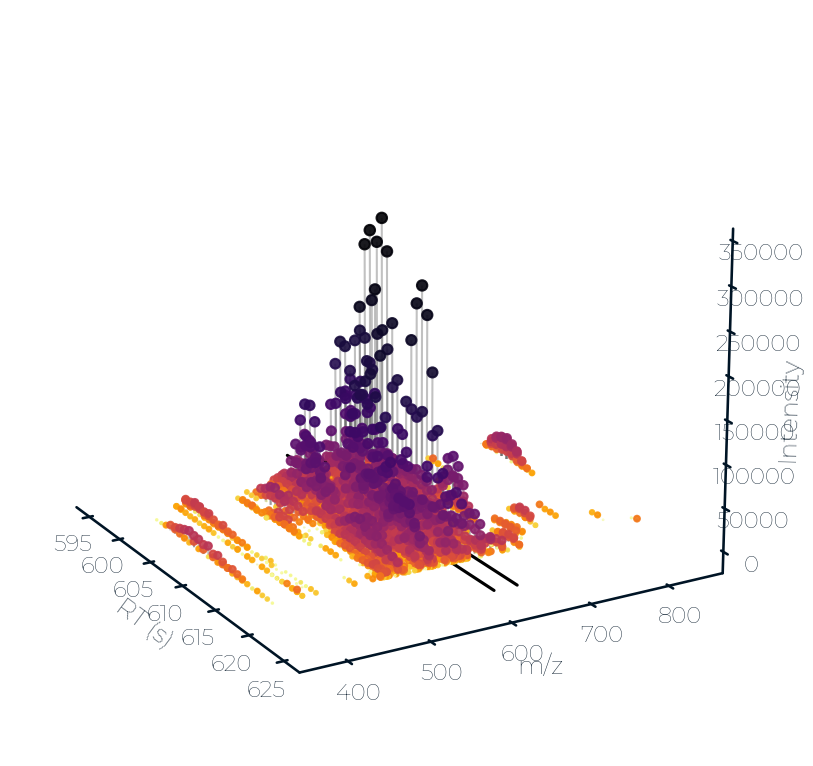

2024-06-02 23:29:13.209 | INFO     | __main__:collapse_to_tolerance:9 - vals_shape: (2, 870), inds_shape: (6325,), intensities_shape: (6325,)
2024-06-02 23:29:13.212 | INFO     | __main__:collapse_to_tolerance:9 - vals_shape: (1, 150), inds_shape: (6325,), intensities_shape: (6325,)
2024-06-02 23:29:13.213 | DEBUG    | __main__:plot_mz_rt_traces:39 - dist_to_top: (150, 870)
2024-06-02 23:29:13.213 | INFO     | __main__:plot_mz_rt_traces:42 - (array([ True]), array([870]))


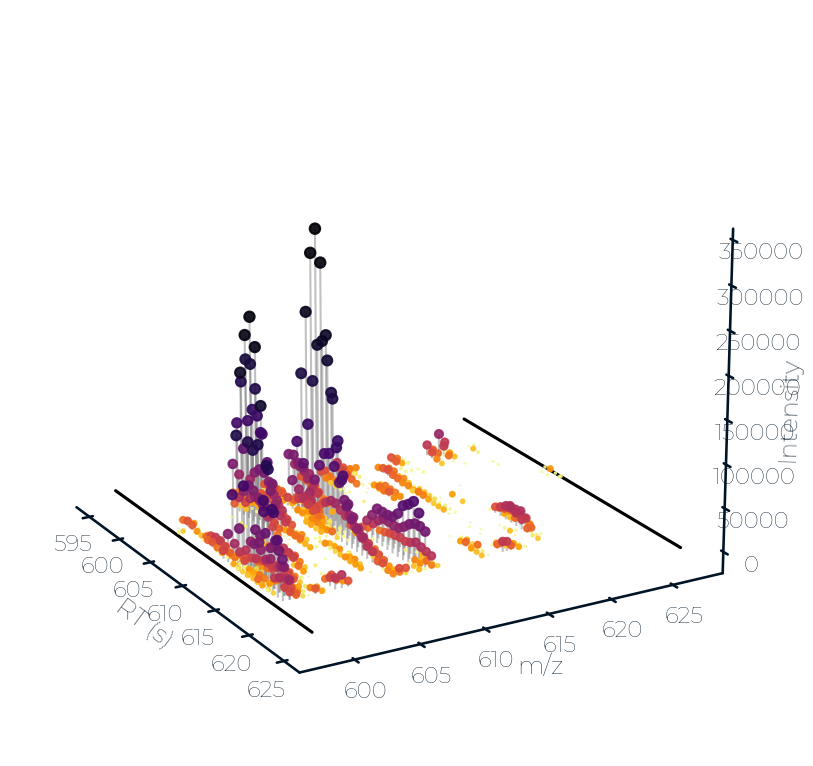

In [22]:
tmp_ms1 = ms1_df.filter(
    pl.col("imss") > 1.0,
    pl.col("imss") < 1.05,
    pl.col("intensities") > 500,
)

# 612.5, isolation_width=25.0,

MARGIN = 2
WIDTH = 25
SB = 612.5 - MARGIN - (WIDTH / 2)
EB = 612.5 + MARGIN + (WIDTH / 2)

fig, ax, stems, scatter = plot_mz_rt_traces(
    tmp_ms1["mzs"].to_numpy(),
    tmp_ms1["rt"].to_numpy(),
    tmp_ms1["intensities"].to_numpy(),
    num_max=500,
)
ax.plot([595, 625], [SB, SB], zs=0, zdir="z", c="black")
ax.plot([595, 625], [EB, EB], zs=0, zdir="z", c="black")

plt.show()


tmp_ms1 = ms1_df.filter(
    pl.col("imss") > 1.0,
    pl.col("imss") < 1.05,
    pl.col("mzs") > SB,
    pl.col("mzs") < EB,
    pl.col("intensities") > 500,
)
fig, ax, stems, scatter = plot_mz_rt_traces(
    tmp_ms1["mzs"].to_numpy(),
    tmp_ms1["rt"].to_numpy(),
    tmp_ms1["intensities"].to_numpy(),
    num_max=500,
)
ax.plot([595, 625], [SB, SB], zs=0, zdir="z", c="black")
ax.plot([595, 625], [EB, EB], zs=0, zdir="z", c="black")

plt.show()

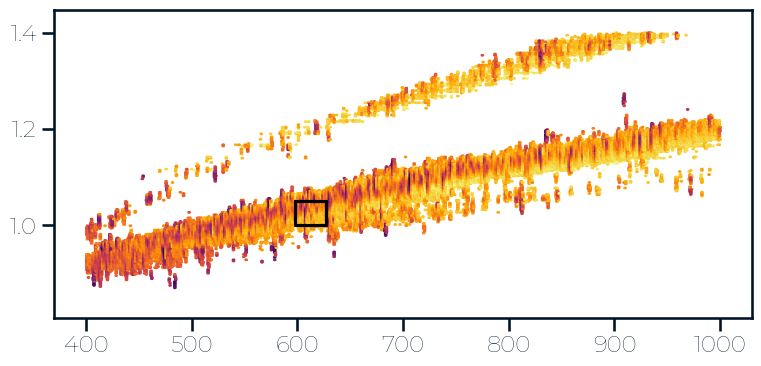

2024-06-02 23:29:15.545 | INFO     | __main__:collapse_to_tolerance:9 - vals_shape: (2, 90672), inds_shape: (129974,), intensities_shape: (129974,)


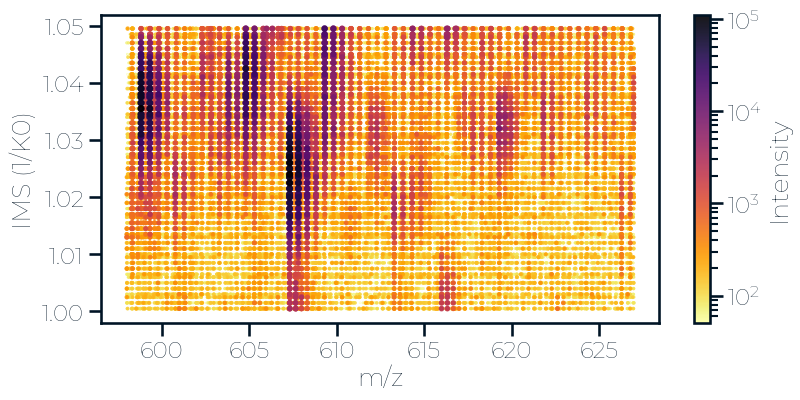

In [23]:
plt.rcParams["figure.figsize"] = (9, 4)

hb_ms1_df = ms1_df.filter(
    pl.col("mzs") > 400,
    pl.col("mzs") < 1000,
)

plt.hexbin(
    hb_ms1_df["mzs"],
    hb_ms1_df["imss"],
    C=np.log(hb_ms1_df["intensities"]),
    gridsize=400,
    cmap="inferno_r",
    mincnt=100,
)
plt.plot([SB, SB], [1.0, 1.05], c="black")
plt.plot([EB, EB], [1.0, 1.05], c="black")
plt.plot([SB, EB], [1.0, 1.0], c="black")
plt.plot([SB, EB], [1.05, 1.05], c="black")
plt.show()

focus_hb_ms1_df = ms1_df.filter(
    pl.col("mzs") > SB,
    pl.col("mzs") < EB,
    pl.col("imss") > 1.0,
    pl.col("imss") < 1.05,
    pl.col("intensities") > 50,
)

(collapsed_mzs, collapsed_imss), collapsed_ints = collapse_to_tolerance(
    focus_hb_ms1_df["mzs"].to_numpy(),
    focus_hb_ms1_df["imss"].to_numpy(),
    intensities=focus_hb_ms1_df["intensities"].to_numpy(),
    tol=0.0005,
)

order = np.argsort(collapsed_ints)
collapsed_mzs = collapsed_mzs[order]
collapsed_imss = collapsed_imss[order]
collapsed_ints = collapsed_ints[order]

plt.scatter(
    collapsed_mzs,
    collapsed_imss,
    s=4 * (np.log10(collapsed_ints) - np.log10(np.min(collapsed_ints))),
    c=collapsed_ints,
    cmap="inferno_r",
    alpha=0.9,
    norm=matplotlib.colors.LogNorm(),
)
plt.xlabel("m/z")
plt.ylabel("IMS (1/K0)")
cb = plt.colorbar()
cb.ax.set_ylabel("Intensity")
plt.show()

2024-06-02 23:29:23.649 | INFO     | __main__:collapse_to_tolerance:9 - vals_shape: (2, 4660203), inds_shape: (10790141,), intensities_shape: (10790141,)


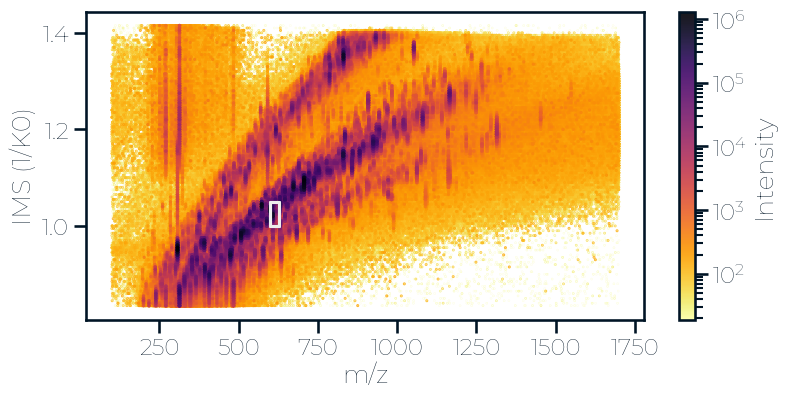

In [24]:
def plot_mz_ims_df(df, tolerance=0.0005, size_scale=4):
    (collapsed_mzs, collapsed_imss), collapsed_ints = collapse_to_tolerance(
        df["mzs"].to_numpy(),
        df["imss"].to_numpy(),
        intensities=df["intensities"].to_numpy(),
        tol=tolerance,
    )

    order = np.argsort(collapsed_ints)
    collapsed_mzs = collapsed_mzs[order]
    collapsed_imss = collapsed_imss[order]
    collapsed_ints = collapsed_ints[order]

    scatter = plt.scatter(
        collapsed_mzs,
        collapsed_imss,
        s=size_scale * (np.log10(collapsed_ints) - np.log10(np.min(collapsed_ints))),
        c=collapsed_ints,
        cmap="inferno_r",
        alpha=0.9,
        norm=matplotlib.colors.LogNorm(),
    )
    plt.xlabel("m/z")
    plt.ylabel("IMS (1/K0)")
    cb = plt.colorbar()
    cb.ax.set_ylabel("Intensity")
    return scatter, cb


plot_mz_ims_df(ms1_df, tolerance=0.005, size_scale=0.5)

box_colour = "#eeeeee"
plt.plot([SB, SB], [1.0, 1.05], c=box_colour)
plt.plot([EB, EB], [1.0, 1.05], c=box_colour)
plt.plot([SB, EB], [1.0, 1.0], c=box_colour)
plt.plot([SB, EB], [1.05, 1.05], c=box_colour)
plt.show()

2024-06-02 23:29:45.414 | INFO     | __main__:collapse_to_tolerance:9 - vals_shape: (2, 7062), inds_shape: (17948,), intensities_shape: (17948,)


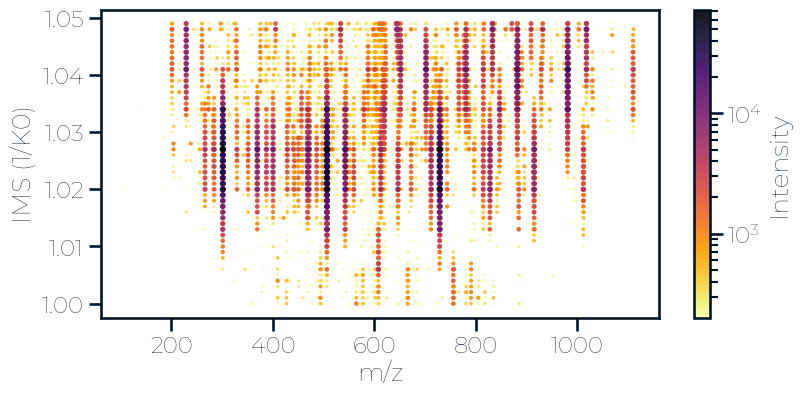

In [25]:
plot_mz_ims_df(sdf, tolerance=np.array([[0.02], [0.001]]), size_scale=4)
plt.show()

2024-06-02 23:29:45.609 | INFO     | __main__:collapse_to_tolerance:9 - vals_shape: (1, 1904), inds_shape: (17948,), intensities_shape: (17948,)


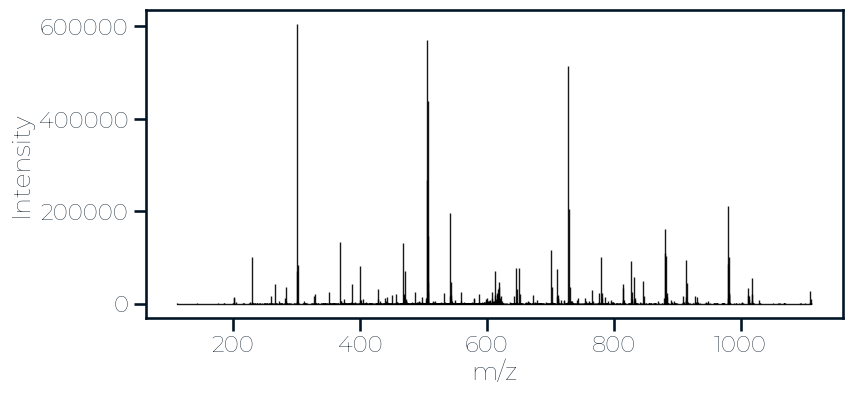

2024-06-02 23:29:45.683 | INFO     | __main__:collapse_to_tolerance:9 - vals_shape: (1, 1904), inds_shape: (17948,), intensities_shape: (17948,)


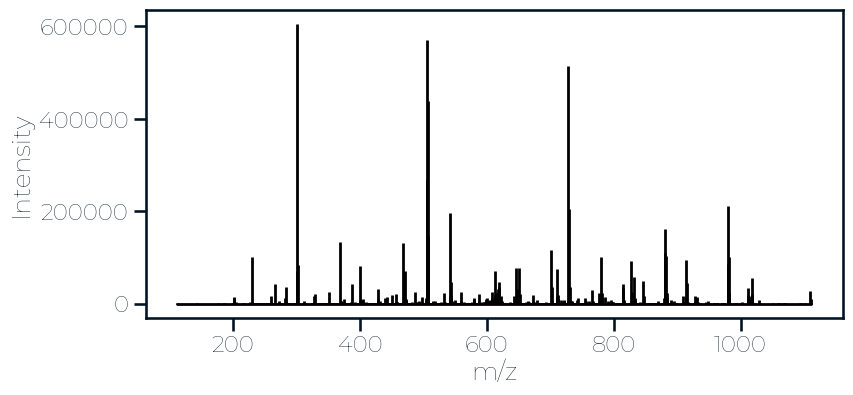

In [26]:
def collapse_mz_df(df, tolerance=0.02):
    """Draw the classic needle plot for m/z data"""
    (collapsed_mzs,), collapsed_ints = collapse_to_tolerance(
        df["mzs"].to_numpy(),
        intensities=df["intensities"].to_numpy(),
        tol=tolerance,
    )

    order = np.argsort(collapsed_ints)
    collapsed_mzs = collapsed_mzs[order]
    collapsed_ints = collapsed_ints[order]
    return collapsed_mzs, collapsed_ints


def plot_mz_df(df, tolerance=0.0005, linewidth=0.5, alpha=0.7):
    collapsed_mzs, collapsed_ints = collapse_mz_df(df, tolerance=tolerance)

    stems = plt.stem(collapsed_mzs, collapsed_ints, linefmt="", markerfmt="")
    plt.setp(stems, "linewidth", linewidth)
    plt.setp(stems, "alpha", alpha)
    plt.setp(stems, "color", "black")
    plt.xlabel("m/z")
    plt.ylabel("Intensity")
    return plt.gca()


plot_mz_df(sdf, tolerance=0.02, linewidth=1, alpha=0.9)
plt.show()
plot_mz_df(sdf, tolerance=0.02, linewidth=2, alpha=1)
plt.show()

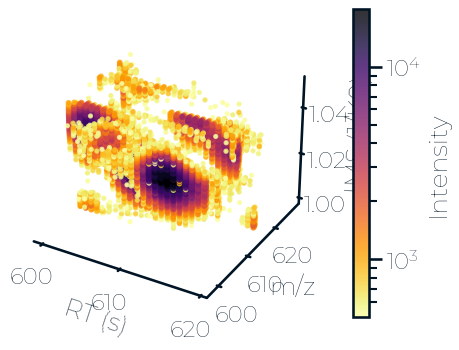

In [27]:
fig, ax = get_3d_default_ax()
# ax.view_init(azim=-30, elev=20)
MIN_INTENSITY_SHOW = 500

focus_cs = focus_hb_ms1_df["intensities"].to_numpy()
focus_min_log10_cs = np.log10(np.min(focus_cs))
focus_scaled_cs = 5 * (np.log10(focus_cs) - focus_min_log10_cs)
curr_filter = focus_cs > MIN_INTENSITY_SHOW
scatter1 = ax.scatter(
    focus_hb_ms1_df[PARAMS["X"]["col"]].to_numpy()[curr_filter],
    focus_hb_ms1_df[PARAMS["Y"]["col"]].to_numpy()[curr_filter],
    focus_hb_ms1_df[PARAMS["Z"]["col"]].to_numpy()[curr_filter],
    s=focus_scaled_cs[curr_filter],
    c=focus_cs[curr_filter],
    cmap="inferno_r",
    alpha=0.8,
    norm=matplotlib.colors.LogNorm(),
)
cb = fig.colorbar(scatter1, ax=ax)
cb.ax.set_ylabel("Intensity")
plt.show()

# Hard coded location of a peptide identified in a later analysis ... I just dont want to move my functions to a separate script ... we are on a deadline here

In [28]:
del qr

In [29]:
file = "../data/231121_RH30_NMIAA_E1_DIA.d"
qr = QuadResolver.from_file(file)

2024-06-02 23:29:45.935 | INFO     | __main__:from_file:94 - Starting reader
2024-06-02 23:29:45.983 | INFO     | __main__:from_file:96 - Reading DIA metadata
2024-06-02 23:29:45.985 | DEBUG    | __main__:mapping_from_sql:64 - [(1, 100, 397, 812.5, 25.0, 43.01094890510949), (1, 397, 545, 612.5, 25.0, 32.43065693430657), (1, 545, 701, 412.5, 25.0, 25.218978102189784), (2, 100, 372, 837.5, 25.0, 43.58029197080292), (2, 372, 528, 637.5, 25.0, 33.42700729927007), (2, 528, 701, 437.5, 25.0, 25.645985401459857), (3, 100, 355, 862.5, 25.0, 44.00729927007299), (3, 355, 512, 662.5, 25.0, 34.23357664233577), (3, 512, 701, 462.5, 25.0, 26.025547445255476), (4, 100, 331, 887.5, 25.0, 44.57664233576642), (4, 331, 487, 687.5, 25.0, 35.37226277372263), (4, 487, 701, 487.5, 25.0, 26.594890510948908), (5, 100, 314, 912.5, 25.0, 44.956204379562045), (5, 314, 471, 712.5, 25.0, 36.17883211678833), (5, 471, 701, 512.5, 25.0, 26.974452554744527), (6, 100, 298, 937.5, 25.0, 45.33576642335767), (6, 298, 454, 

In [30]:
from pprint import pprint

mz = 737.49
# pprint(qr.group_to_windows)
matching_windows = {
    k: [w for w in v if abs(w.isolation_mz - mz) < (w.isolation_width / 2)]
    for k, v in qr.group_to_windows.items()
}
pprint(matching_windows)

{1: [],
 2: [],
 3: [],
 4: [],
 5: [],
 6: [DiaWindow(group=6,
               scan_begin=298,
               scan_end=454,
               isolation_mz=737.5,
               isolation_width=25.0,
               collision_energy=36.93795620437956)],
 7: [],
 8: []}


In [31]:
qr.group_to_windows[6]

[DiaWindow(group=6, scan_begin=100, scan_end=298, isolation_mz=937.5, isolation_width=25.0, collision_energy=45.33576642335767),
 DiaWindow(group=6, scan_begin=298, scan_end=454, isolation_mz=737.5, isolation_width=25.0, collision_energy=36.93795620437956),
 DiaWindow(group=6, scan_begin=454, scan_end=701, isolation_mz=537.5, isolation_width=25.0, collision_energy=27.4014598540146)]

In [32]:
rt_center_secs = 635.5432
rt_window = 3
# rt_window = 10
frame_group = 6
peptide_seq = "LVVPATQC[+71.03711]GSLIGK"
df = qr.get_windowgroup_denseframe_range(
    rt_center_secs - rt_window,
    rt_center_secs + rt_window,
    group=frame_group,
)
ms1_df = qr.get_ms1_denseframe_range(start_mins * 60, (start_mins * 60) + range_secs)
print(ms1_df)
print(df)

2024-06-02 23:30:09.265 | INFO     | __main__:get_windowgroup_denseframe_range:127 - Sample window group -> DiaWindow(group=6, scan_begin=100, scan_end=298, isolation_mz=937.5, isolation_width=25.0, collision_energy=45.33576642335767)
2024-06-02 23:30:09.588 | DEBUG    | __main__:get_ms1_denseframe_range:142 - Reading 817 to 844


shape: (10_915_642, 4)
┌────────────┬─────────────┬─────────────┬──────────┐
│ rt         ┆ intensities ┆ mzs         ┆ imss     │
│ ---        ┆ ---         ┆ ---         ┆ ---      │
│ f64        ┆ i64         ┆ f64         ┆ f64      │
╞════════════╪═════════════╪═════════════╪══════════╡
│ 600.315717 ┆ 195         ┆ 253.089126  ┆ 1.418544 │
│ 600.315717 ┆ 21          ┆ 255.60438   ┆ 1.41767  │
│ 600.315717 ┆ 170         ┆ 307.406897  ┆ 1.41767  │
│ 600.315717 ┆ 18          ┆ 585.960032  ┆ 1.41767  │
│ 600.315717 ┆ 19          ┆ 1092.906526 ┆ 1.41767  │
│ …          ┆ …           ┆ …           ┆ …        │
│ 619.408249 ┆ 149         ┆ 404.859323  ┆ 0.835728 │
│ 619.408249 ┆ 179         ┆ 405.213748  ┆ 0.835728 │
│ 619.408249 ┆ 75          ┆ 554.67047   ┆ 0.835728 │
│ 619.408249 ┆ 38          ┆ 554.698121  ┆ 0.835728 │
│ 619.408249 ┆ 19          ┆ 982.694616  ┆ 0.835728 │
└────────────┴─────────────┴─────────────┴──────────┘
shape: (361_418, 4)
┌────────────┬─────────────┬───────────

2024-06-02 23:30:19.459 | INFO     | __main__:collapse_to_tolerance:9 - vals_shape: (2, 5526541), inds_shape: (10915642,), intensities_shape: (10915642,)


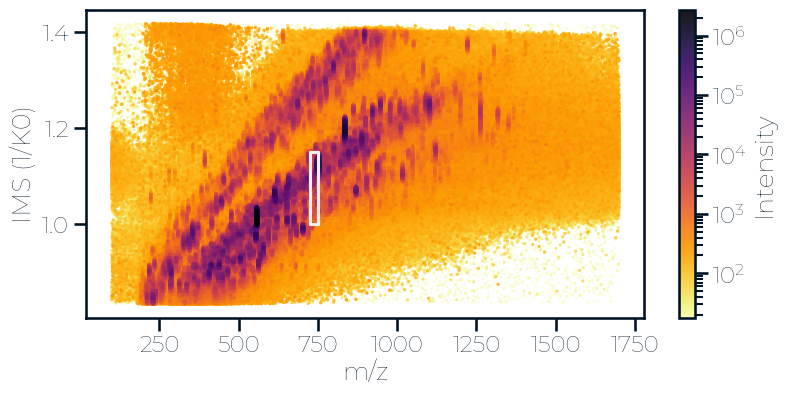

In [33]:
plot_mz_ims_df(ms1_df, tolerance=np.array([[0.02], [0.001]]), size_scale=1)
box_colour = "#eeeeee"
SB = 725
EB = 750
plt.plot([SB, SB], [1.15, 1.0], c=box_colour)
plt.plot([EB, EB], [1.15, 1.0], c=box_colour)
plt.plot([SB, EB], [1.15, 1.15], c=box_colour)
plt.plot([SB, EB], [1.0, 1.0], c=box_colour)
plt.show()

2024-06-02 23:30:45.912 | INFO     | __main__:collapse_to_tolerance:9 - vals_shape: (2, 112648), inds_shape: (304678,), intensities_shape: (304678,)


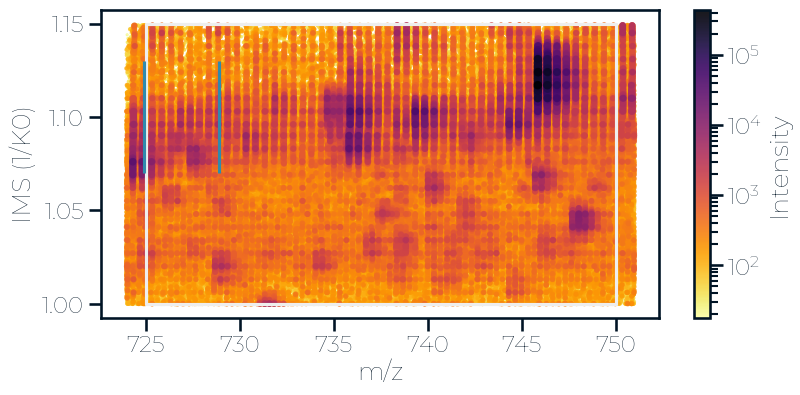

2024-06-02 23:30:46.818 | INFO     | __main__:collapse_to_tolerance:9 - vals_shape: (2, 291602), inds_shape: (361418,), intensities_shape: (361418,)


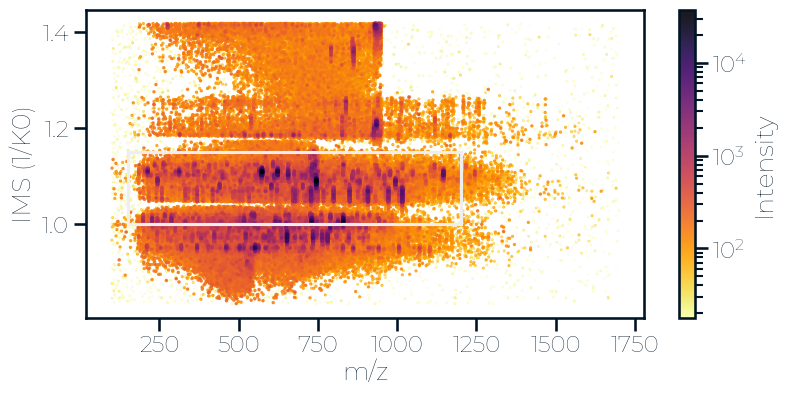

In [34]:
plot_mz_ims_df(
    ms1_df.filter(
        pl.col("mzs").is_between(724, 751),
        pl.col("imss").is_between(1.0, 1.15),
    ),
    tolerance=np.array([[0.02], [0.001]]),
    size_scale=5,
)
box_colour = "#eeeeee"
SB = 725
EB = 750
plt.plot([SB, SB], [1.15, 1.0], c=box_colour)
plt.plot([EB, EB], [1.15, 1.0], c=box_colour)
plt.plot([SB, EB], [1.15, 1.15], c=box_colour)
plt.plot([SB, EB], [1.0, 1.0], c=box_colour)
plt.vlines([727.90605 - 3, 727.90605 + 1], ymin=1.07, ymax=1.13)
plt.show()

plot_mz_ims_df(df, tolerance=np.array([[0.02], [0.001]]), size_scale=1)
SB = 150
EB = 1200
plt.plot([SB, SB], [1.15, 1.0], c=box_colour)
plt.plot([EB, EB], [1.15, 1.0], c=box_colour)
plt.plot([SB, EB], [1.15, 1.15], c=box_colour)
plt.plot([SB, EB], [1.0, 1.0], c=box_colour)
plt.show()

2024-06-02 23:30:48.292 | INFO     | __main__:get_windowgroup_denseframe_range:127 - Sample window group -> DiaWindow(group=6, scan_begin=100, scan_end=298, isolation_mz=937.5, isolation_width=25.0, collision_energy=45.33576642335767)
2024-06-02 23:30:48.583 | INFO     | __main__:collapse_to_tolerance:9 - vals_shape: (2, 103492), inds_shape: (140995,), intensities_shape: (140995,)


(<matplotlib.collections.PathCollection at 0x39963a1e0>,
 <matplotlib.colorbar.Colorbar at 0x30b07c800>)

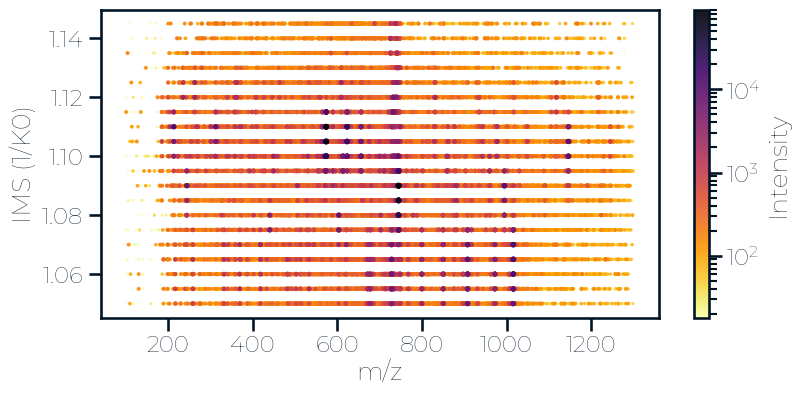

In [35]:
df = qr.get_windowgroup_denseframe_range(
    rt_center_secs - rt_window,
    rt_center_secs + rt_window,
    group=frame_group,
).filter(
    pl.col("imss") > 1.05,
    pl.col("imss") < 1.15,
    pl.col("mzs") < 1300,
)

plot_mz_ims_df(df, tolerance=0.005, size_scale=2)

2024-06-02 23:30:50.192 | INFO     | __main__:collapse_to_tolerance:9 - vals_shape: (1, 24105), inds_shape: (140995,), intensities_shape: (140995,)


<Axes: xlabel='m/z', ylabel='Intensity'>

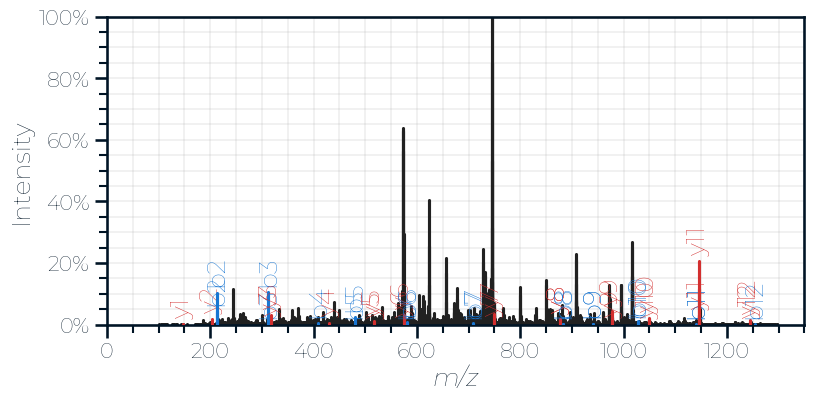

In [36]:
# collapse_mz_df()
import spectrum_utils.spectrum as sus
import spectrum_utils.plot as sup

mzs, ints = collapse_mz_df(df)
spec = sus.MsmsSpectrum(
    "asdasd",
    precursor_mz=1472.9856,
    precursor_charge=2,
    mz=mzs,
    intensity=ints,
)

spec = spec.annotate_proforma(
    peptide_seq, fragment_tol_mass=0.02, fragment_tol_mode="Da"
)
sup.spectrum(spec)

In [37]:
def xyz_from_df(df):
    ys = df[PARAMS["Y"]["col"]].to_numpy()
    zs = df[PARAMS["Z"]["col"]].to_numpy()
    xs = df[PARAMS["X"]["col"]].to_numpy()
    return xs, ys, zs

In [38]:
annotated_masses = [
    m for m, a in zip(spec.mz, spec.annotation) if a.fragment_annotations
]
annotated_masses = np.array(annotated_masses)
annotated_masses

array([ 147.12,  204.12,  213.14,  213.16,  312.22,  312.24,  317.2 ,
        317.22,  409.28,  430.3 ,  480.3 ,  480.32,  517.32,  517.34,
        574.34,  574.36,  581.36,  581.38,  709.42,  709.44,  748.4 ,
        748.42,  876.46,  876.48,  883.46,  883.48,  940.48,  940.5 ,
        977.5 ,  977.52, 1027.52, 1027.54, 1048.54, 1048.56, 1140.6 ,
       1140.62, 1145.58, 1145.6 , 1244.66, 1244.68, 1253.68])

2024-06-02 23:30:58.586 | INFO     | __main__:collapse_to_tolerance:9 - vals_shape: (2, 103492), inds_shape: (140995,), intensities_shape: (140995,)


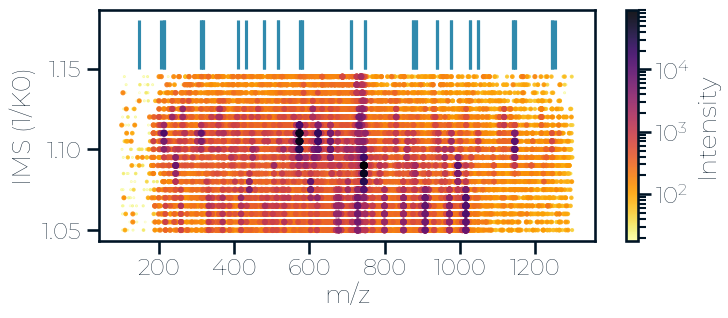

In [39]:
plt.rcParams["figure.figsize"] = (8, 3)
plot_mz_ims_df(df, tolerance=0.005, size_scale=5)
plt.vlines(annotated_masses, ymin=1.18, ymax=1.15)
plt.show()

2024-06-02 23:30:59.293 | INFO     | __main__:collapse_to_tolerance:9 - vals_shape: (2, 112789), inds_shape: (125833,), intensities_shape: (125833,)


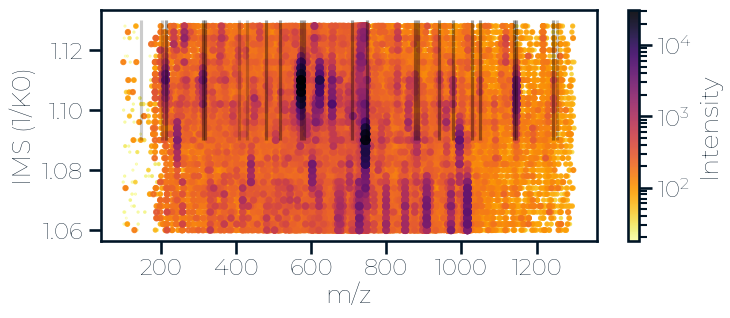

2024-06-02 23:31:00.014 | INFO     | __main__:collapse_to_tolerance:9 - vals_shape: (2, 112789), inds_shape: (125833,), intensities_shape: (125833,)


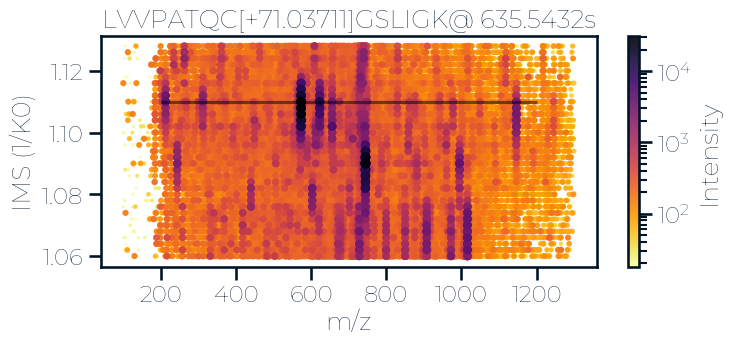

In [40]:
plt.rcParams["figure.figsize"] = (8, 3)
plot_mz_ims_df(
    df.filter(pl.col("imss") > 1.06, pl.col("imss") < 1.13),
    tolerance=0.002,
    size_scale=10,
)
ims_center = 1.11
ims_halfwidth = 0.02
plt.vlines(
    annotated_masses,
    ymin=ims_center + ims_halfwidth,
    ymax=ims_center - ims_halfwidth,
    color="black",
    alpha=0.2,
)
plt.show()
# plt.vlines(annotated_masses, ymin=1.18, ymax=1.15)

plot_mz_ims_df(
    df.filter(pl.col("imss") > 1.06, pl.col("imss") < 1.13),
    tolerance=0.002,
    size_scale=10,
)
plt.hlines(
    [ims_center],
    xmin=200,
    xmax=1200,
    color="black",
    alpha=0.5,
)
plt.title(peptide_seq + "@ 635.5432s")
plt.show()
# plt.vlines(annotated_masses, ymin=1.18, ymax=1.15)

2024-06-02 23:31:00.734 | INFO     | __main__:collapse_to_tolerance:9 - vals_shape: (2, 764), inds_shape: (1885,), intensities_shape: (1885,)


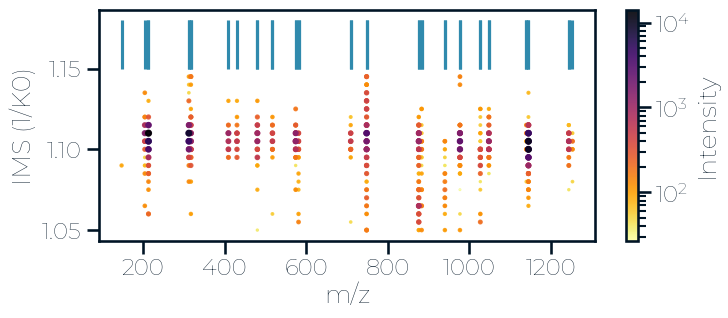

In [41]:
any_annotated_mz = np.any(
    np.abs((df["mzs"].to_numpy() - np.expand_dims(annotated_masses, -1))) < 0.02, axis=0
)
any_annotated_mz

plt.rcParams["figure.figsize"] = (8, 3)
plot_mz_ims_df(df.filter(any_annotated_mz), tolerance=0.005, size_scale=5)
plt.vlines(annotated_masses, ymin=1.18, ymax=1.15)

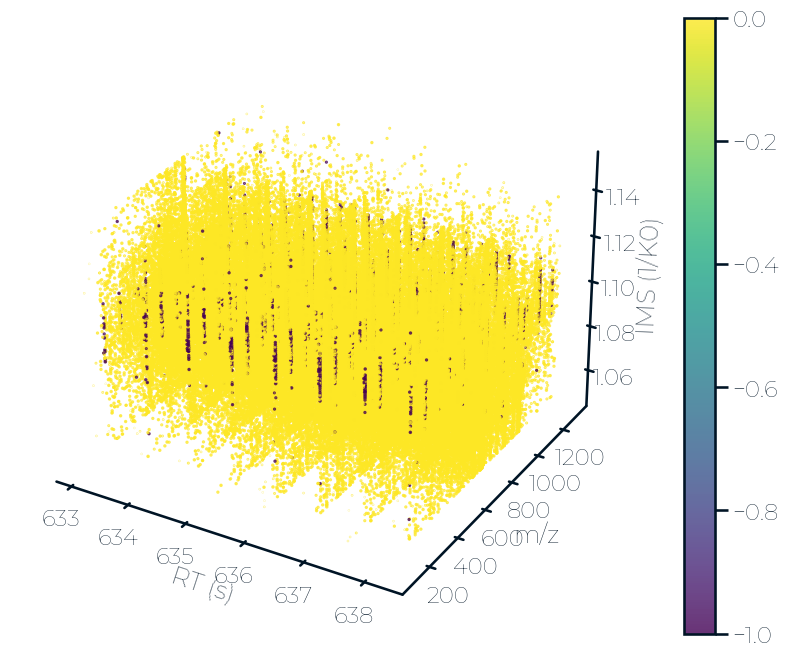

In [42]:
plt.rcParams["figure.figsize"] = (15, 8)

xs, ys, zs = xyz_from_df(df)
scaled_int = df["intensities"].to_numpy()
scaled_int = np.log10(scaled_int) - np.log10(min(scaled_int))

fig, ax = get_3d_default_ax()
scatter1 = ax.scatter(
    xs,
    ys,
    zs,
    s=scaled_int,
    c=-1 * any_annotated_mz,
    alpha=0.8,
)
fig.colorbar(scatter1, ax=ax)
plt.show()

In [43]:
foo = sus.proforma.parse("LVVPATQC[+71.03711]GSLIGK/2")[0]